In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
from tqdm import tqdm
pd.set_option('display.max_columns', None)

In [2]:
df_raw = pd.read_csv('myanimelist_recommender_ready_enriched.csv')


In [3]:
df_raw['score'] = df_raw['score'].apply(lambda x: str(x).rstrip('0').rstrip('.') if isinstance(x, float) else x)
df_raw['rank'] = df_raw['rank'].apply(lambda x: str(x).rstrip('0').rstrip('.') if isinstance(x, float) else x)
df_raw['members'] = df_raw['members'].apply(lambda x: f"{int(x):,}" if isinstance(x, int) else x)
mal_ids = [35677, 41457, 52991, 33352] 
df_filtered = df_raw[df_raw['mal_id'].isin(mal_ids)]
print(df_filtered[['mal_id', 'title_english', 'title_japanese', 'type', 'status', 'score', 'rank', 'members']].head().to_latex(index=False).replace("_", "\\_"))

\begin{tabular}{rlllllll}
\toprule
mal\_id & title\_english & title\_japanese & type & status & score & rank & members \\
\midrule
33352 & Violet Evergarden & ヴァイオレット・エヴァーガーデン & TV & Finished Airing & 8.68 & 67 & 1,904,842 \\
35677 & Liz and the Blue Bird & リズと青い鳥 & Movie & Finished Airing & 8.22 & 375 & 154,915 \\
41457 & 86 Eighty-Six & 86―エイティシックス― & TV & Finished Airing & 8.33 & 255 & 890,163 \\
52991 & Frieren: Beyond Journey's End & 葬送のフリーレン & TV & Finished Airing & 9.3 & 1 & 1,140,504 \\
\bottomrule
\end{tabular}



In [4]:
df_raw = pd.read_csv('myanimelist_recommender_ready_enriched.csv')

In [5]:
df_raw.shape

(28707, 28)

In [6]:
df_raw.columns

Index(['mal_id', 'title', 'title_english', 'title_japanese', 'type',
       'episodes', 'status', 'score', 'rank', 'popularity', 'members',
       'favorites', 'synopsis', 'genres', 'themes', 'demographics', 'studios',
       'year', 'url', 'aired_date', 'review_tags_count', 'Creative',
       'MixedFeelings', 'Recommended', 'Funny', 'NotRecommended',
       'Informative', 'Well-written'],
      dtype='object')

In [7]:
df_raw.demographics.unique()

array([nan, 'Shounen', 'Josei', 'Seinen', 'Shoujo', 'Kids',
       'Kids, Shounen', 'Kids, Shoujo', 'Seinen, Shounen'], dtype=object)

In [8]:
df_processed = df_raw.copy()
df_processed = df_processed[df_processed['type'].isin(['TV', 'Movie'])]
df_processed.shape

(13239, 28)

In [9]:
missing_values = df_processed.isnull().sum()
missing_values[missing_values > 0]


title_english        6303
title_japanese         29
episodes              390
score                5369
rank                  437
synopsis             3420
genres               1980
themes               6084
demographics         6823
studios              4971
year                  587
aired_date            587
review_tags_count    7186
dtype: int64

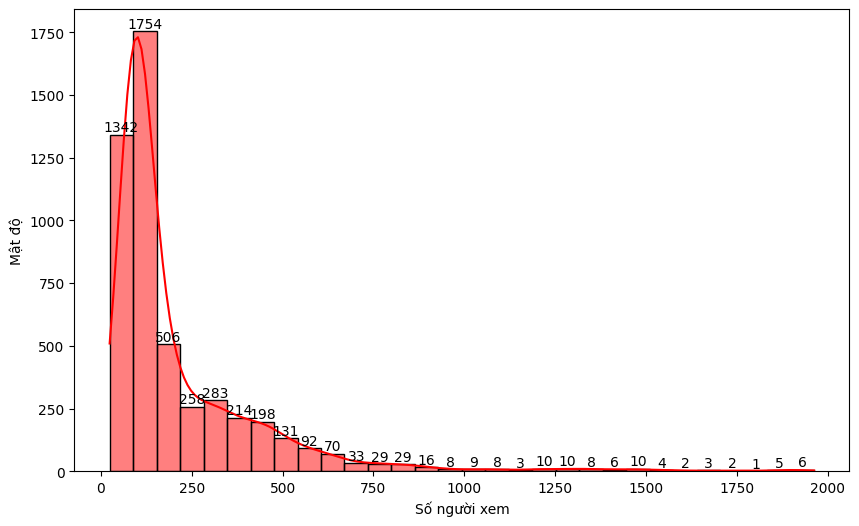

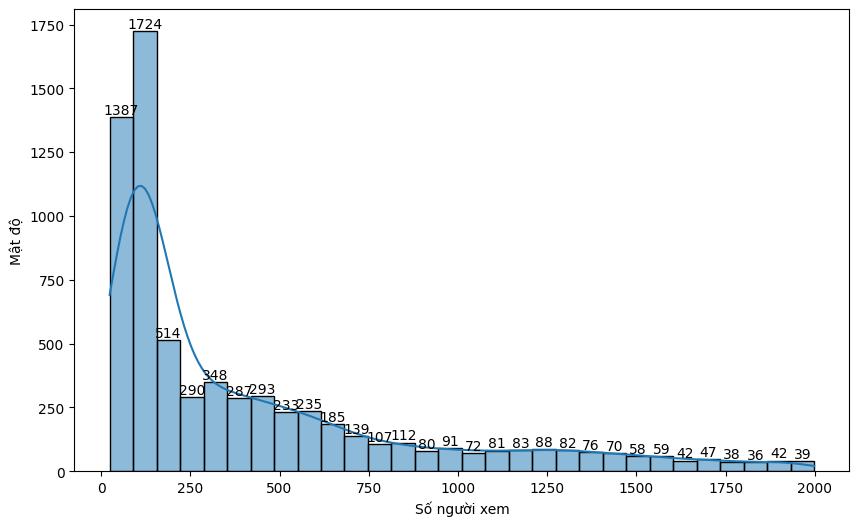

In [10]:
plt.figure(figsize=(10, 6))
df_processed_temp = df_processed[(df_processed['score'].isna()) & (df_processed['members'] < 2000 )].copy()

sns.histplot(
    data=df_processed_temp,
    x='members',
    kde=True,
    color='red',
    stat='count',
    legend=False,
    bins=30
)
for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width() / 2, p.get_height(), 
             f'{p.get_height()}' if p.get_height() != 0 else '0',
             ha='center', va='bottom', fontsize=10, color='black')


plt.xlabel('Số người xem')
plt.ylabel('Mật độ')
plt.show()

plt.figure(figsize=(10, 6))

sns.histplot(
    data=df_processed[df_processed['members'] < 2000],
    x='members',
    kde=True,
    stat='count',
    legend=False,
    bins=30
)
for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width() / 2, p.get_height(), 
             f'{p.get_height()}' if p.get_height() != 0 else '0',
             ha='center', va='bottom', fontsize=10, color='black')


plt.xlabel('Số người xem')
plt.ylabel('Mật độ')
plt.show()

In [11]:
df_processed = df_processed[df_processed['score'].notna()]
df_processed.shape

(7870, 28)

In [12]:
missing_values = df_processed.isnull().sum()
missing_values[missing_values > 0]

title_english        2517
title_japanese         22
episodes               34
rank                   21
synopsis              119
genres                377
themes               2578
demographics         5043
studios              1052
year                    4
aired_date              4
review_tags_count    1895
dtype: int64

In [13]:
def one_hot_multilabel(df, col, sep=', ', prefix=None, keep_original=False):
    prefix = prefix or f"{col}_"
    
    df[col] = (
        df[col]
          .fillna('')   
          .apply(lambda s: s.split(sep)
                 if isinstance(s, str) else s) 
    )

    dummies = (
        df[col].str.join('|') 
          .str.get_dummies()   
          .add_prefix(prefix)    
    )

    if keep_original:
        return df.join(dummies)     
    else:
        return pd.concat([df.drop(columns=[col]),   
                           dummies],
                          axis=1)

for col in ['genres', 'themes', 'demographics']:
    df_processed = one_hot_multilabel(df_processed, col, keep_original=True)

In [14]:
df_processed.head(2)


,mal_id,title,title_english,title_japanese,type,episodes,status,score,rank,popularity,members,favorites,synopsis,genres,themes,demographics,studios,year,url,aired_date,review_tags_count,Creative,MixedFeelings,Recommended,Funny,NotRecommended,Informative,Well-written,genres_Action,genres_Adventure,genres_Avant Garde,genres_Award Winning,genres_Boys Love,genres_Comedy,genres_Drama,genres_Ecchi,genres_Erotica,genres_Fantasy,genres_Girls Love,genres_Gourmet,genres_Hentai,genres_Horror,genres_Mystery,genres_Romance,genres_Sci-Fi,genres_Slice of Life,genres_Sports,genres_Supernatural,genres_Suspense,themes_Adult Cast,themes_Anthropomorphic,themes_CGDCT,themes_Childcare,themes_Combat Sports,themes_Crossdressing,themes_Delinquents,themes_Detective,themes_Educational,themes_Gag Humor,themes_Gore,themes_Harem,themes_High Stakes Game,themes_Historical,themes_Idols (Female),themes_Idols (Male),themes_Isekai,themes_Iyashikei,themes_Love Polygon,themes_Love Status Quo,themes_Magical Sex Shift,themes_Mahou Shoujo,themes_Martial Arts,themes_Mecha,themes_Medical,themes_Military,themes_Music,themes_Mythology,themes_Organized Crime,themes_Otaku Culture,themes_Parody,themes_Performing Arts,themes_Pets,themes_Psychological,themes_Racing,themes_Reincarnation,themes_Reverse Harem,themes_Samurai,themes_School,themes_Showbiz,themes_Space,themes_Strategy Game,themes_Super Power,themes_Survival,themes_Team Sports,themes_Time Travel,themes_Urban Fantasy,themes_Vampire,themes_Video Game,themes_Villainess,themes_Visual Arts,themes_Workplace,demographics_Josei,demographics_Kids,demographics_Seinen,demographics_Shoujo,demographics_Shounen
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,TV,26.0,Finished Airing,8.75,46.0,42,1975882,86621,"Crime is timeless. By the year 2071, humanity ...","[Action, Award Winning, Sci-Fi]","[Adult Cast, Space]",[],Sunrise,1998.0,https://myanimelist.net/anime/1/Cowboy_Bebop,1998-04-03T00:00:00+00:00,"{'Recommended': 16, 'Mixed Feelings': 2, 'Not ...",0,2,16,0,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,Movie,1.0,Finished Airing,8.38,215.0,642,398122,1711,"Another day, another bounty—such is the life o...","[Action, Sci-Fi]","[Adult Cast, Space]",[],Bones,2001.0,https://myanimelist.net/anime/5/Cowboy_Bebop__...,2001-09-01T00:00:00+00:00,"{'Recommended': 15, 'Mixed Feelings': 3, 'Not ...",0,3,15,1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
df_processed.shape

(7870, 106)

In [16]:
categories = ['title', 'title_english', 'title_japanese', 'type', 'status', 'url', 'review_tags_count']
numeric = ['mal_id', 'episodes', 'score', 'rank', 'popularity', 'members', 'year', 'aired_date', 'Creative', 'MixedFeelings', 'Recommended', 'Funny', 'NotRecommended', 'Informative', 'Well-written']

In [17]:
categories = ['type', 'status']
numeric = ['episodes', 'score', 'rank', 'popularity', 'favorite', 'members', 'year', 'aired_date', 'MixedFeelings', 'Recommended', 'NotRecommended']

In [18]:
df = df_processed.copy()

summary_stats = {
    " ": [
        "Mean",
        "Min",
        "Q1",
        "Median",
        "Q3",
        "Max",
        "Mode",
        "Var",
        "SD",
        "CV",
        "IQR"
    ]
}

quantitative_cols = ['score', 'favorites', 'members',  'Recommended', 'MixedFeelings', 'NotRecommended']

def create_summary_df(df, quantitative_cols):
    for col in quantitative_cols:
        data = df[col]
        mean_val = data.mean()
        std_val = data.std()
        mode_val = data.mode().iloc[0] if not data.mode().empty else np.nan
        variance_val = data.var()
        cv_val = std_val / mean_val if mean_val != 0 else np.nan

        summary_stats[col] = [
            mean_val,
            data.min(),
            data.quantile(0.25),
            data.median(),
            data.quantile(0.75),
            data.max(),
            mode_val,
            variance_val,
            std_val,
            cv_val,
            data.quantile(0.75) - data.quantile(0.25)
        ]

    formatted_summary_df = pd.DataFrame(summary_stats).copy()

    for col in formatted_summary_df.columns[1:]:  # Skip "Thông số thống kê"
        formatted_summary_df[col] = formatted_summary_df[col].apply(lambda x: f'{x:,.4f}' if isinstance(x, (int, float)) else x)

    return formatted_summary_df

formatted_summary_df = create_summary_df(df, quantitative_cols)
formatted_summary_df = formatted_summary_df.applymap(lambda x: x.rstrip('0').rstrip('.') if isinstance(x, str) else x)
formatted_summary_df

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11072\2534549043.py:52: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_summary_df = formatted_summary_df.applymap(lambda x: x.rstrip('0').rstrip('.') if isinstance(x, str) else x)


,,score,favorites,members,Recommended,MixedFeelings,NotRecommended
0,Mean,6.669,"1,485.5222","120,803.3152",5.0469,1.5848,1.3471
1,Min,2,0,206,0,0,0
2,Q1,6.07,3,"2,162.5",0,0,0
3,Median,6.7,32,"15,593.5",2,1,0
4,Q3,7.33,346,"100,486",9,3,2
5,Max,9.3,"238,872","4,173,914",20,13,17
6,Mode,6.42,0,423,0,0,0
7,Var,0.8738,"71,446,951.132","88,430,158,687.0622",34.0366,4.2754,5.4627
8,SD,0.9348,"8,452.6298","297,372.0879",5.8341,2.0677,2.3372
9,CV,0.1402,5.69,2.4616,1.156,1.3047,1.735


In [19]:
print(formatted_summary_df.to_latex(index=False).replace("_", "\\_"))

\begin{tabular}{lllllll}
\toprule
  & score & favorites & members & Recommended & MixedFeelings & NotRecommended \\
\midrule
Mean & 6.669 & 1,485.5222 & 120,803.3152 & 5.0469 & 1.5848 & 1.3471 \\
Min & 2 & 0 & 206 & 0 & 0 & 0 \\
Q1 & 6.07 & 3 & 2,162.5 & 0 & 0 & 0 \\
Median & 6.7 & 32 & 15,593.5 & 2 & 1 & 0 \\
Q3 & 7.33 & 346 & 100,486 & 9 & 3 & 2 \\
Max & 9.3 & 238,872 & 4,173,914 & 20 & 13 & 17 \\
Mode & 6.42 & 0 & 423 & 0 & 0 & 0 \\
Var & 0.8738 & 71,446,951.132 & 88,430,158,687.0622 & 34.0366 & 4.2754 & 5.4627 \\
SD & 0.9348 & 8,452.6298 & 297,372.0879 & 5.8341 & 2.0677 & 2.3372 \\
CV & 0.1402 & 5.69 & 2.4616 & 1.156 & 1.3047 & 1.735 \\
IQR & 1.26 & 343 & 98,323.5 & 9 & 3 & 2 \\
\bottomrule
\end{tabular}



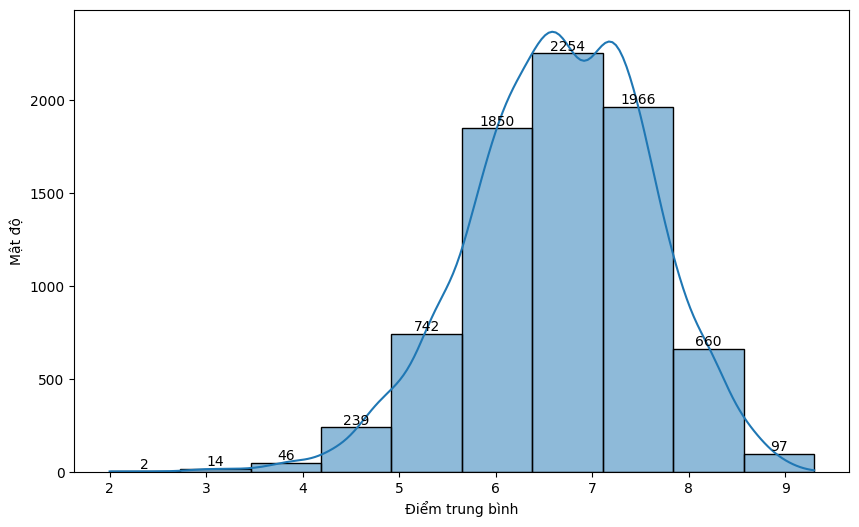

In [20]:
plt.figure(figsize=(10, 6))

sns.histplot(
    data=df_processed,
    x='score',
    kde=True,
    stat='count',
    legend=False,
    bins=10
)
for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width() / 2, p.get_height(), 
             f'{p.get_height()}' if p.get_height() != 0 else '0',
             ha='center', va='bottom', fontsize=10, color='black')


plt.xlabel('Điểm trung bình')
plt.ylabel('Mật độ')
plt.show()

In [21]:
# score -> score_label, 0 -> less than 6 is bad, 6-7 is average, 7-8 is good, above 8 is great

df_processed['score_label'] = pd.cut(df_processed['score'],
                          bins=[-np.inf, 6, 7, 8, np.inf], 
                            labels=['Bad', 'Average', 'Good', 'Great'])
df_processed.head(2)

,mal_id,title,title_english,title_japanese,type,episodes,status,score,rank,popularity,members,favorites,synopsis,genres,themes,demographics,studios,year,url,aired_date,review_tags_count,Creative,MixedFeelings,Recommended,Funny,NotRecommended,Informative,Well-written,genres_Action,genres_Adventure,genres_Avant Garde,genres_Award Winning,genres_Boys Love,genres_Comedy,genres_Drama,genres_Ecchi,genres_Erotica,genres_Fantasy,genres_Girls Love,genres_Gourmet,genres_Hentai,genres_Horror,genres_Mystery,genres_Romance,genres_Sci-Fi,genres_Slice of Life,genres_Sports,genres_Supernatural,genres_Suspense,themes_Adult Cast,themes_Anthropomorphic,themes_CGDCT,themes_Childcare,themes_Combat Sports,themes_Crossdressing,themes_Delinquents,themes_Detective,themes_Educational,themes_Gag Humor,themes_Gore,themes_Harem,themes_High Stakes Game,themes_Historical,themes_Idols (Female),themes_Idols (Male),themes_Isekai,themes_Iyashikei,themes_Love Polygon,themes_Love Status Quo,themes_Magical Sex Shift,themes_Mahou Shoujo,themes_Martial Arts,themes_Mecha,themes_Medical,themes_Military,themes_Music,themes_Mythology,themes_Organized Crime,themes_Otaku Culture,themes_Parody,themes_Performing Arts,themes_Pets,themes_Psychological,themes_Racing,themes_Reincarnation,themes_Reverse Harem,themes_Samurai,themes_School,themes_Showbiz,themes_Space,themes_Strategy Game,themes_Super Power,themes_Survival,themes_Team Sports,themes_Time Travel,themes_Urban Fantasy,themes_Vampire,themes_Video Game,themes_Villainess,themes_Visual Arts,themes_Workplace,demographics_Josei,demographics_Kids,demographics_Seinen,demographics_Shoujo,demographics_Shounen,score_label
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,TV,26.0,Finished Airing,8.75,46.0,42,1975882,86621,"Crime is timeless. By the year 2071, humanity ...","[Action, Award Winning, Sci-Fi]","[Adult Cast, Space]",[],Sunrise,1998.0,https://myanimelist.net/anime/1/Cowboy_Bebop,1998-04-03T00:00:00+00:00,"{'Recommended': 16, 'Mixed Feelings': 2, 'Not ...",0,2,16,0,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Great
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,Movie,1.0,Finished Airing,8.38,215.0,642,398122,1711,"Another day, another bounty—such is the life o...","[Action, Sci-Fi]","[Adult Cast, Space]",[],Bones,2001.0,https://myanimelist.net/anime/5/Cowboy_Bebop__...,2001-09-01T00:00:00+00:00,"{'Recommended': 15, 'Mixed Feelings': 3, 'Not ...",0,3,15,1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Great


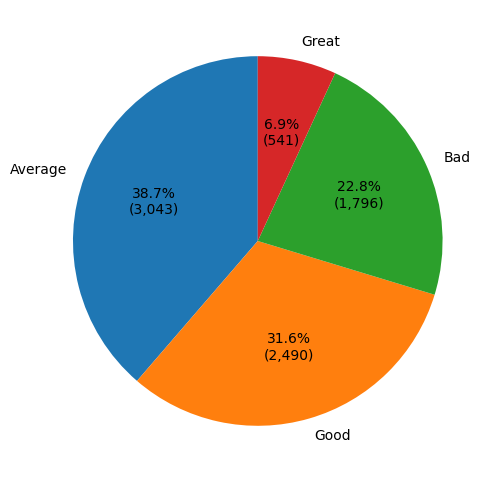

In [22]:
# Pie chart of score labels with counts 
plt.figure(figsize=(10, 6))
counts = df_processed['score_label'].value_counts()

def autopct_format(pct):
    total = sum(counts)
    count = int(round(pct * total / 100.0))
    return f'{pct:.1f}%\n({count:,})'

plt.pie(
    counts,
    labels=counts.index,
    autopct=autopct_format,
    startangle=90,
)

plt.show()



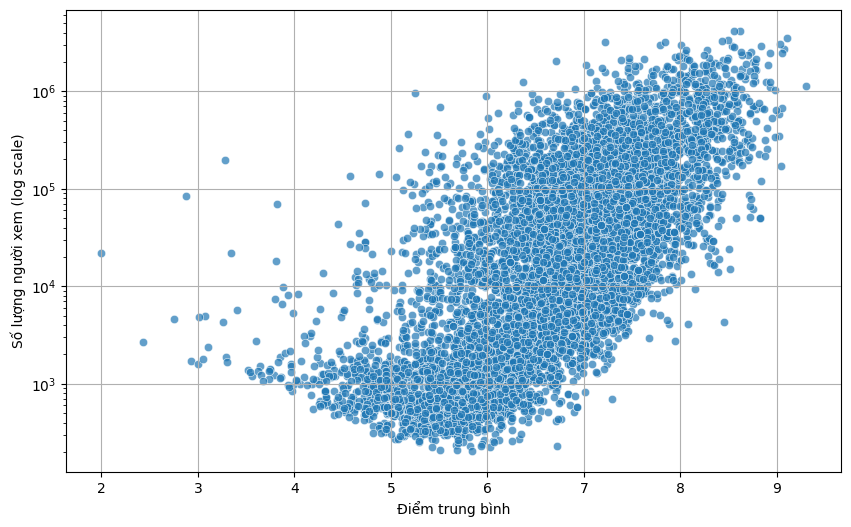

In [23]:
plt.figure(figsize=(10, 6))
plt.yscale('log')
sns.scatterplot(
    data=df_processed,
    x='score',
    y='members',
    # hue='score_label',
    alpha=0.7
)
plt.ylabel('Số lượng người xem (log scale)')
plt.xlabel('Điểm trung bình')
plt.grid(True)
plt.show()

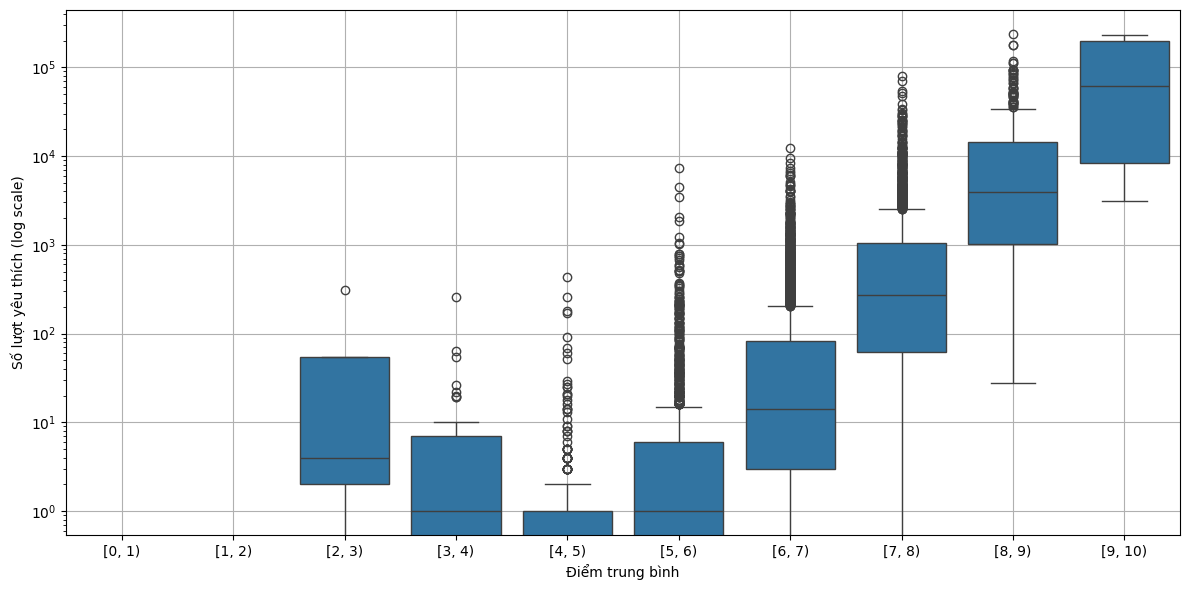

In [24]:
bin_edges = list(range(0, 11))
df_processed['score_bin'] = pd.cut(
    df_processed['score'],
    bins=bin_edges,
    include_lowest=True,
    right=False,  
)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_processed, x='score_bin', y='favorites')

plt.yscale('log')
plt.xlabel('Điểm trung bình')
plt.ylabel('Số lượt yêu thích (log scale)')
plt.grid(True)
plt.tight_layout()
plt.show()

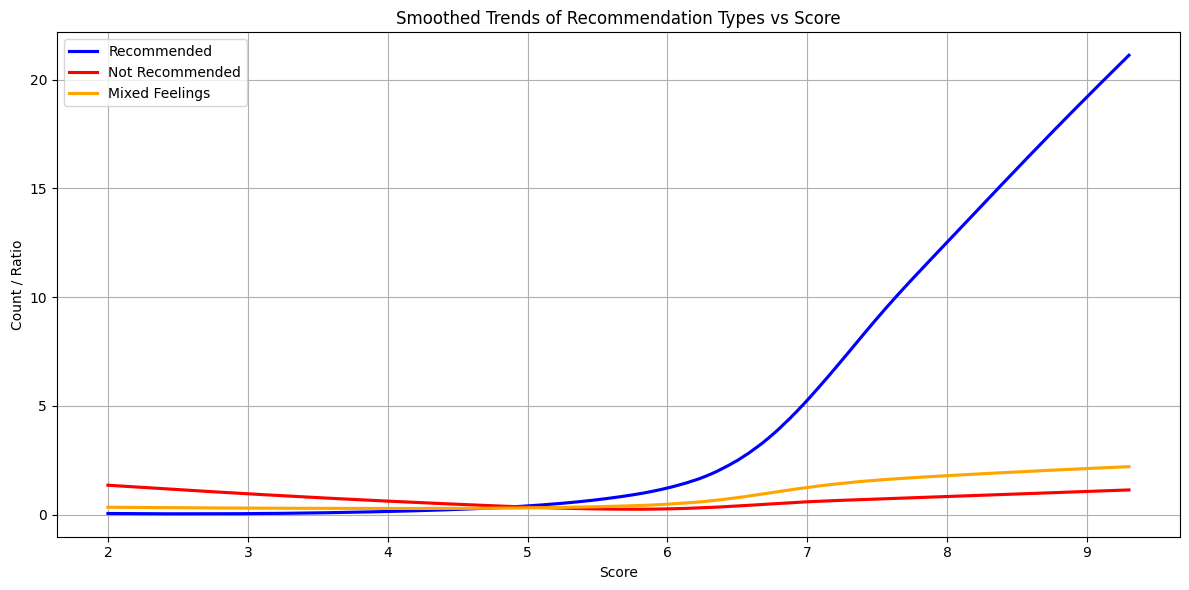

In [25]:
import statsmodels.api as sm  # needed if lowess is used

plt.figure(figsize=(12, 6))

sns.regplot(
    data=df_processed,
    x='score',
    y='Recommended',
    label='Recommended',
    lowess=True,
    scatter=False,
    color='blue'
)
sns.regplot(
    data=df_processed,
    x='score',
    y='NotRecommended',
    label='Not Recommended',
    lowess=True,
    scatter=False,
    color='red'
)
sns.regplot(
    data=df_processed,
    x='score',
    y='MixedFeelings',
    label='Mixed Feelings',
    lowess=True,
    scatter=False,
    color='orange'
)

plt.xlabel("Score")
plt.ylabel("Count / Ratio")
plt.title("Smoothed Trends of Recommendation Types vs Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11072\2654381700.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


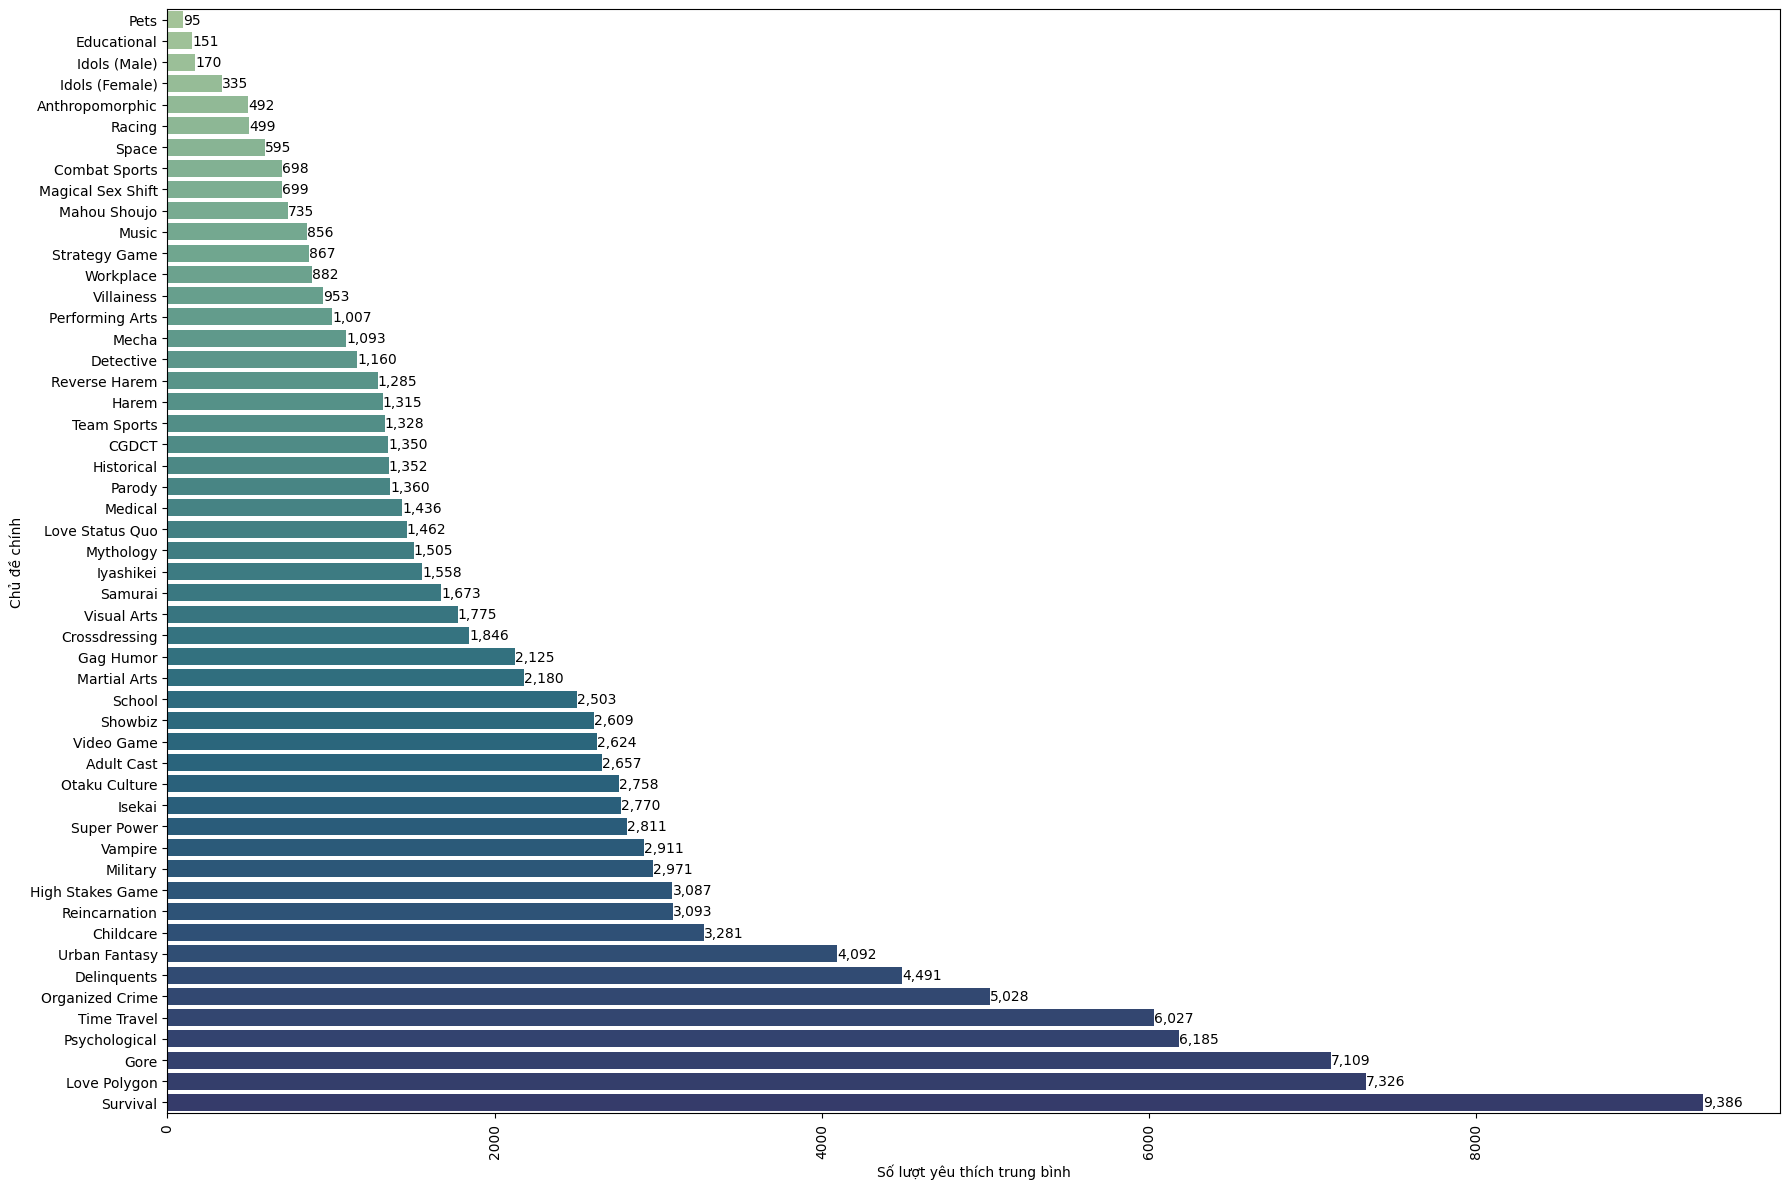

In [26]:
# Average favorites by themes, remove the surfix theme_ from the column names
theme_list = df_processed['themes'].explode().unique().tolist()
theme_list = [theme for theme in theme_list if theme not in ['']]

# Create a DataFrame to hold the average favorites for each theme
theme_avg_favorites = pd.DataFrame(index=theme_list, columns=['avg_favorites'])
for theme in theme_list:
    theme_col = f'themes_{theme}'
    if theme_col in df_processed.columns:
        theme_avg_favorites.loc[theme, 'avg_favorites'] = df_processed[df_processed[theme_col] == 1]['favorites'].mean()

theme_avg_favorites = theme_avg_favorites.dropna().sort_values(by='avg_favorites', ascending=False)


plt.figure(figsize=(18, 12))
theme_avg_favorites = theme_avg_favorites.sort_values(by='avg_favorites', ascending=True)
sns.barplot(
    data=theme_avg_favorites.reset_index(),
    x='avg_favorites',
    y='index',
    palette='crest'
)
for index, value in enumerate(theme_avg_favorites['avg_favorites']):
    plt.text(value, index, f'{value:,.0f}', va='center', fontsize=10, color='black')
plt.xticks(rotation=90)
plt.xlabel('Số lượt yêu thích trung bình')
plt.ylabel('Chủ đề chính')
plt.tight_layout()
plt.show()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11072\3853614842.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  genre_demographic_scores = genre_demographic_scores.fillna(0)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11072\3853614842.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  genre_demographic_favorites = genre_demographic_favorites.fillna(0)


Minimum score (excluding 0): 5.83
Maximum score: 7.86


Text(120.72222222222221, 0.5, 'Thể loại')

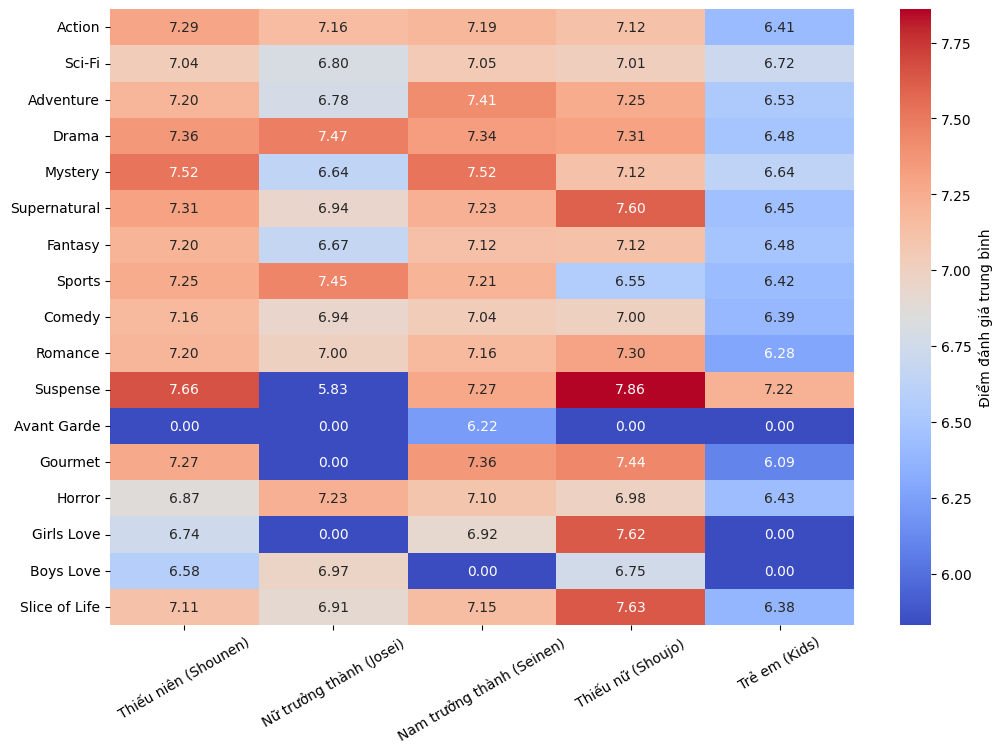

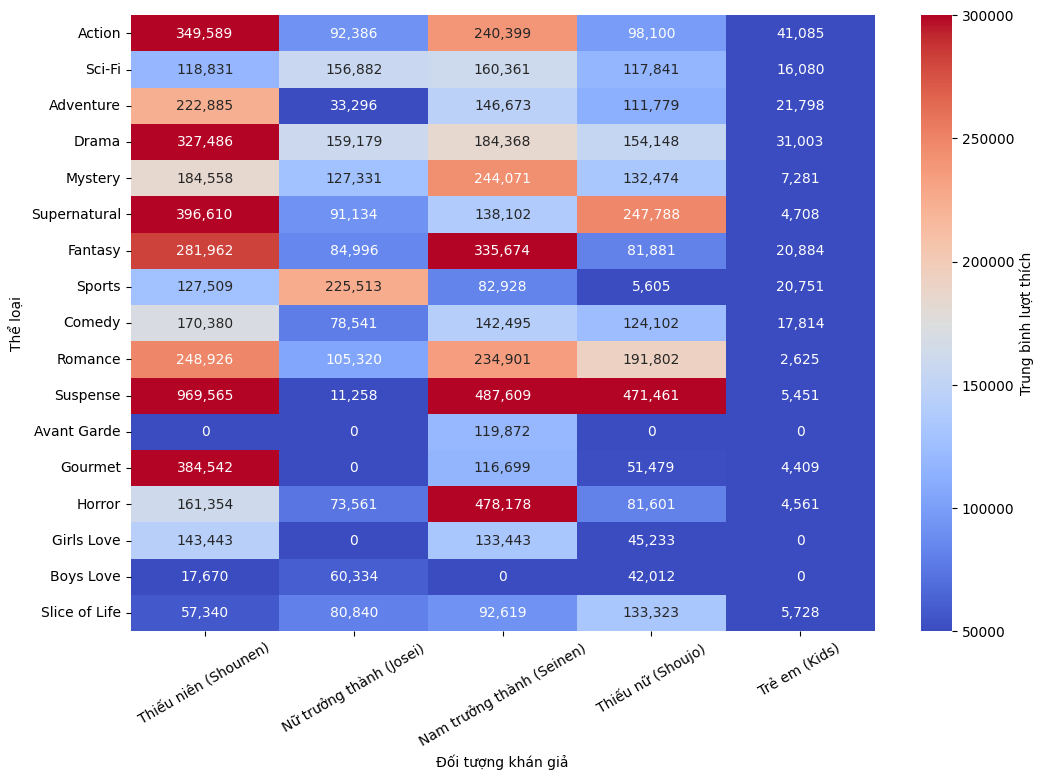

In [27]:
genre_list = df_processed['genres'].explode().unique().tolist()
genre_list = [genre for genre in genre_list if genre not in ['', 'Award Winning', 'Hentai', 'Erotica', 'Ecchi']]

demographic_list = df_processed['demographics'].explode().unique().tolist()
demographic_list = [d for d in demographic_list if d not in ['']]
demographic_list

# genre_list y col, demographic_list x col, x-y contains the avarage score of the anime in that genre and demographic, fillna with 0
genre_demographic_scores = pd.DataFrame(
    index=genre_list,
    columns=demographic_list,
)
for genre in genre_list:
    for demographic in demographic_list:
        avg_score = df_processed[
            (df_processed['genres'].apply(lambda x: genre in x)) &
            (df_processed['demographics'].apply(lambda x: demographic in x))
        ]['score'].mean()
        genre_demographic_scores.loc[genre, demographic] = avg_score
genre_demographic_scores = genre_demographic_scores.fillna(0)

# find min that is not 0
min_score = genre_demographic_scores[genre_demographic_scores > 0].min().min()
print(f"Minimum score (excluding 0): {min_score:.2f}")
max_score = genre_demographic_scores.max().max()
print(f"Maximum score: {max_score:.2f}")


# make another one with average number of favorites instead of score
genre_demographic_favorites = pd.DataFrame(
    index=genre_list,
    columns=demographic_list,
)
for genre in genre_list:
    for demographic in demographic_list:
        avg_favorites = df_processed[
            (df_processed['genres'].apply(lambda x: genre in x)) &
            (df_processed['demographics'].apply(lambda x: demographic in x))
        ]['members'].mean()
        genre_demographic_favorites.loc[genre, demographic] = avg_favorites
genre_demographic_favorites = genre_demographic_favorites.fillna(0)

q1 = genre_demographic_favorites.quantile(0.25).min()
q3 = genre_demographic_favorites.quantile(0.75).max()
iqr = q3 - q1

demographic_list_vi = ['Thiếu niên (Shounen)', 'Nữ trưởng thành (Josei)', 'Nam trưởng thành (Seinen)', 'Thiếu nữ (Shoujo)', 'Trẻ em (Kids)']
genre_demographic_scores.columns = demographic_list_vi
genre_demographic_favorites.columns = demographic_list_vi

plt.figure(figsize=(12, 8))
sns.heatmap(
    genre_demographic_scores,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmin=min_score,
    vmax=max_score,
    cbar_kws={'label': 'Điểm đánh giá trung bình'},
)   
plt.xticks(rotation=30)


from matplotlib.colors import LogNorm, Normalize
plt.figure(figsize=(12, 8))
sns.heatmap(
    genre_demographic_favorites,
    annot=True,
    fmt=",.0f",
    cmap='coolwarm',
    vmin=50000 ,
    vmax=300000 ,
    cbar_kws={'label': 'Trung bình lượt thích'},
    #norm=LogNorm()
)
plt.xticks(rotation=30)
plt.xlabel('Đối tượng khán giả')
plt.ylabel('Thể loại')

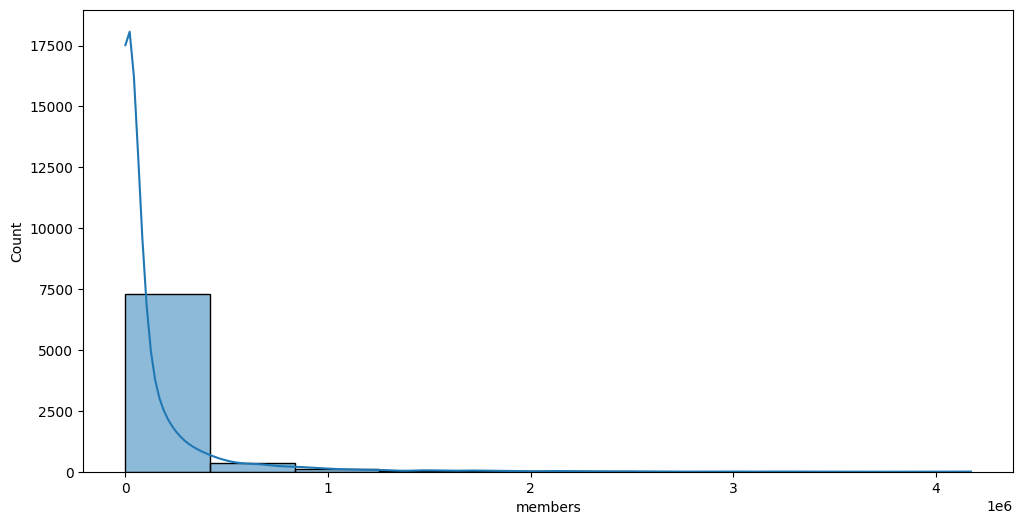

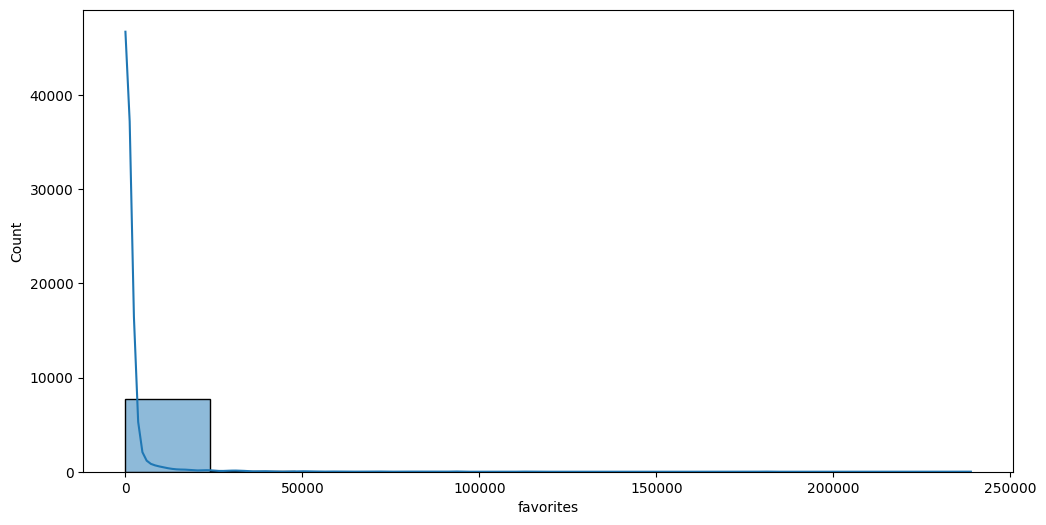

In [28]:

plt.figure(figsize=(12, 6))
sns.histplot(
    data=df_processed,
    x='members',
    kde=True,
    stat='count',
    legend=False,
    bins=10
)


plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(
    data=df_processed,
    x='favorites',
    kde=True,
    stat='count',
    legend=False,
    bins=10
)


plt.show()

In [29]:
df_processed['score_label_as_int'] = df_processed['score_label'].map({
    'Bad': 0,
    'Average': 1,
    'Good': 2,
    'Great': 3
})

In [30]:

df_processed['log_members'] = np.log1p(df_processed['members'])
df_processed['log_favorites'] = np.log1p(df_processed['favorites'])

df_processed['members_label_as_int'] = pd.qcut(
    df_processed['log_members'],
    q=4,
    labels=[0, 1, 2, 3]
).astype(int)

df_processed['favorites_label_as_int'] = pd.qcut(
    df_processed['log_favorites'],
    q=4,
    labels=[0, 1, 2, 3]
).astype(int)

In [31]:
from category_encoders import LeaveOneOutEncoder

encoder = LeaveOneOutEncoder(cols=['studios'])

encoded = encoder.fit_transform(df_processed[['studios']], df_processed['score'])

df_processed['studio_encoded'] = encoded['studios']

In [32]:
df_processed.head(2)

,mal_id,title,title_english,title_japanese,type,episodes,status,score,rank,popularity,members,favorites,synopsis,genres,themes,demographics,studios,year,url,aired_date,review_tags_count,Creative,MixedFeelings,Recommended,Funny,NotRecommended,Informative,Well-written,genres_Action,genres_Adventure,genres_Avant Garde,genres_Award Winning,genres_Boys Love,genres_Comedy,genres_Drama,genres_Ecchi,genres_Erotica,genres_Fantasy,genres_Girls Love,genres_Gourmet,genres_Hentai,genres_Horror,genres_Mystery,genres_Romance,genres_Sci-Fi,genres_Slice of Life,genres_Sports,genres_Supernatural,genres_Suspense,themes_Adult Cast,themes_Anthropomorphic,themes_CGDCT,themes_Childcare,themes_Combat Sports,themes_Crossdressing,themes_Delinquents,themes_Detective,themes_Educational,themes_Gag Humor,themes_Gore,themes_Harem,themes_High Stakes Game,themes_Historical,themes_Idols (Female),themes_Idols (Male),themes_Isekai,themes_Iyashikei,themes_Love Polygon,themes_Love Status Quo,themes_Magical Sex Shift,themes_Mahou Shoujo,themes_Martial Arts,themes_Mecha,themes_Medical,themes_Military,themes_Music,themes_Mythology,themes_Organized Crime,themes_Otaku Culture,themes_Parody,themes_Performing Arts,themes_Pets,themes_Psychological,themes_Racing,themes_Reincarnation,themes_Reverse Harem,themes_Samurai,themes_School,themes_Showbiz,themes_Space,themes_Strategy Game,themes_Super Power,themes_Survival,themes_Team Sports,themes_Time Travel,themes_Urban Fantasy,themes_Vampire,themes_Video Game,themes_Villainess,themes_Visual Arts,themes_Workplace,demographics_Josei,demographics_Kids,demographics_Seinen,demographics_Shoujo,demographics_Shounen,score_label,score_bin,score_label_as_int,log_members,log_favorites,members_label_as_int,favorites_label_as_int,studio_encoded
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,TV,26.0,Finished Airing,8.75,46.0,42,1975882,86621,"Crime is timeless. By the year 2071, humanity ...","[Action, Award Winning, Sci-Fi]","[Adult Cast, Space]",[],Sunrise,1998.0,https://myanimelist.net/anime/1/Cowboy_Bebop,1998-04-03T00:00:00+00:00,"{'Recommended': 16, 'Mixed Feelings': 2, 'Not ...",0,2,16,0,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Great,"[8, 9)",3,14.496526,11.369309,3,3,7.053493
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,Movie,1.0,Finished Airing,8.38,215.0,642,398122,1711,"Another day, another bounty—such is the life o...","[Action, Sci-Fi]","[Adult Cast, Space]",[],Bones,2001.0,https://myanimelist.net/anime/5/Cowboy_Bebop__...,2001-09-01T00:00:00+00:00,"{'Recommended': 15, 'Mixed Feelings': 3, 'Not ...",0,3,15,1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Great,"[8, 9)",3,12.894516,7.445418,3,3,7.507471


In [33]:
# check missing or empty genres, themes, demographics (each are list of strings)
# For df_processed, genres, themes, demographics are lists of strings (after one-hot encoding step)
missing_genres = df_processed[df_processed['genres'].apply(lambda x: not isinstance(x, list) or len(x) == 0 or (isinstance(x, list) and (len(x) == 1 and (x[0] == '' or pd.isna(x[0])))))]
missing_themes = df_processed[df_processed['themes'].apply(lambda x: not isinstance(x, list) or len(x) == 0 or (isinstance(x, list) and (len(x) == 1 and (x[0] == '' or pd.isna(x[0])))))]
missing_demographics = df_processed[df_processed['demographics'].apply(lambda x: not isinstance(x, list) or len(x) == 0 or (isinstance(x, list) and (len(x) == 1 and (x[0] == '' or pd.isna(x[0])))))]

print(f"Missing genres: {len(missing_genres)}")
print(f"Missing themes: {len(missing_themes)}")
print(f"Missing demographics: {len(missing_demographics)}")


Missing genres: 377
Missing themes: 2578
Missing demographics: 5043


In [34]:

df_processed_2 = df_processed.drop(missing_genres.index, errors='ignore')
df_processed_2 = df_processed_2.drop(missing_themes.index, errors='ignore') 
df_processed_2.shape


(5017, 114)

In [35]:
df_processed_2.head(2)

,mal_id,title,title_english,title_japanese,type,episodes,status,score,rank,popularity,members,favorites,synopsis,genres,themes,demographics,studios,year,url,aired_date,review_tags_count,Creative,MixedFeelings,Recommended,Funny,NotRecommended,Informative,Well-written,genres_Action,genres_Adventure,genres_Avant Garde,genres_Award Winning,genres_Boys Love,genres_Comedy,genres_Drama,genres_Ecchi,genres_Erotica,genres_Fantasy,genres_Girls Love,genres_Gourmet,genres_Hentai,genres_Horror,genres_Mystery,genres_Romance,genres_Sci-Fi,genres_Slice of Life,genres_Sports,genres_Supernatural,genres_Suspense,themes_Adult Cast,themes_Anthropomorphic,themes_CGDCT,themes_Childcare,themes_Combat Sports,themes_Crossdressing,themes_Delinquents,themes_Detective,themes_Educational,themes_Gag Humor,themes_Gore,themes_Harem,themes_High Stakes Game,themes_Historical,themes_Idols (Female),themes_Idols (Male),themes_Isekai,themes_Iyashikei,themes_Love Polygon,themes_Love Status Quo,themes_Magical Sex Shift,themes_Mahou Shoujo,themes_Martial Arts,themes_Mecha,themes_Medical,themes_Military,themes_Music,themes_Mythology,themes_Organized Crime,themes_Otaku Culture,themes_Parody,themes_Performing Arts,themes_Pets,themes_Psychological,themes_Racing,themes_Reincarnation,themes_Reverse Harem,themes_Samurai,themes_School,themes_Showbiz,themes_Space,themes_Strategy Game,themes_Super Power,themes_Survival,themes_Team Sports,themes_Time Travel,themes_Urban Fantasy,themes_Vampire,themes_Video Game,themes_Villainess,themes_Visual Arts,themes_Workplace,demographics_Josei,demographics_Kids,demographics_Seinen,demographics_Shoujo,demographics_Shounen,score_label,score_bin,score_label_as_int,log_members,log_favorites,members_label_as_int,favorites_label_as_int,studio_encoded
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,TV,26.0,Finished Airing,8.75,46.0,42,1975882,86621,"Crime is timeless. By the year 2071, humanity ...","[Action, Award Winning, Sci-Fi]","[Adult Cast, Space]",[],Sunrise,1998.0,https://myanimelist.net/anime/1/Cowboy_Bebop,1998-04-03T00:00:00+00:00,"{'Recommended': 16, 'Mixed Feelings': 2, 'Not ...",0,2,16,0,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Great,"[8, 9)",3,14.496526,11.369309,3,3,7.053493
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,Movie,1.0,Finished Airing,8.38,215.0,642,398122,1711,"Another day, another bounty—such is the life o...","[Action, Sci-Fi]","[Adult Cast, Space]",[],Bones,2001.0,https://myanimelist.net/anime/5/Cowboy_Bebop__...,2001-09-01T00:00:00+00:00,"{'Recommended': 15, 'Mixed Feelings': 3, 'Not ...",0,3,15,1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Great,"[8, 9)",3,12.894516,7.445418,3,3,7.507471


In [36]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import RobustScaler

def run_kfold_pipeline(
        df_raw: pd.DataFrame,
        ft_cols_qualitative: list[str],
        ft_cols_qualitative_to_one_hot: list[str],
        ft_cols_quantitative: list[str],
        target_col: str,
        scaler,
        model,
        n_splits: int = 5,
        random_state: int = 42,
        shuffle: bool = True,
        scoring=None
    ):
    
    binary_flag_cols = list(set(ft_cols_qualitative) - set(ft_cols_qualitative_to_one_hot))

    preprocessor = ColumnTransformer(
        transformers=[
            ("num",    scaler,                                   ft_cols_quantitative),
            ("onehot", OneHotEncoder(handle_unknown="ignore"),   ft_cols_qualitative_to_one_hot),
            ("binary", "passthrough",                            binary_flag_cols)
        ],
        remainder="drop"
    )

    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", model)
    ])

    X = df_raw.drop(columns=[target_col])
    y = df_raw[target_col]

    cv = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    results = cross_validate(pipe, X, y, cv=cv, n_jobs=-1,
                             return_train_score=True, scoring=scoring)

    return results

In [37]:
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, roc_auc_score

scoring = {
    "acc": "accuracy",
    "recall": make_scorer(recall_score, average='macro'),
    "precision": make_scorer(precision_score, average='macro'),
    "f1": make_scorer(f1_score, average='macro'),
}

In [41]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

def run_exp(df_input, ft_cols_qualitative, ft_cols_qualitative_to_one_hot, ft_cols_quantitative, target_col, scaler):
    df_run = df_input[ft_cols_qualitative + ft_cols_quantitative + [target_col]].copy()

    list_max_iter = [10, 20, 30, 40, 50, 100, 200, 300, 500]
    list_cs = [1,2,3,4,5,8,10]
    best_parameters = {
        "max_iter": None,
        "cs": None,
        "test_acc": -math.inf,
        "cv_scores": None
    }

    for max_iter, cs in tqdm(itertools.product(list_max_iter, list_cs), 
                            total=len(list_max_iter) * len(list_cs), 
                            desc="Running Logistic Regression CV"):
        cv_run = run_kfold_pipeline(
            df_raw=df_run,
            ft_cols_qualitative=ft_cols_qualitative,
            ft_cols_qualitative_to_one_hot=ft_cols_qualitative_to_one_hot,
            ft_cols_quantitative=ft_cols_quantitative,
            target_col=target_col,
            scaler=scaler,
            model=LogisticRegressionCV(
                max_iter=max_iter,
                Cs=cs,
            ),
            scoring = scoring
        )
        
        mean_test_acc = cv_run["test_acc"].mean()
        
        if mean_test_acc > best_parameters["test_acc"]:
            best_parameters["max_iter"] = max_iter
            best_parameters["cs"] = cs
            best_parameters["test_acc"] = mean_test_acc
            best_parameters["cv_scores"] = cv_run

    print(f"Best parameters LogClass: {best_parameters}")
    cv_scores_logistic = best_parameters["cv_scores"]

    list_max_depth = [2, 3, 5, 10]
    list_n_estimators = [50, 100, 150, 200]
    list_min_samples_leaf = [3, 5, 10, 20]

    best_parameters = {
        "max_depth": None,
        "n_estimators": None,
        "min_samples_leaf": None,
        "test_acc": -math.inf,
        "cv_scores": None
    }

    for max_depth, n_estimators, min_samples_leaf in tqdm(
        itertools.product(list_max_depth, list_n_estimators, list_min_samples_leaf),
        total=len(list_max_depth) * len(list_n_estimators) * len(list_min_samples_leaf)
    ):    
        cv_run = run_kfold_pipeline(
            df_raw=df_run,
            ft_cols_qualitative=ft_cols_qualitative,
            ft_cols_qualitative_to_one_hot=ft_cols_qualitative_to_one_hot,
            ft_cols_quantitative=ft_cols_quantitative,
            target_col=target_col,
            scaler=scaler,
            model=RandomForestClassifier(
                max_depth=max_depth,
                n_estimators=n_estimators,
                min_samples_leaf=min_samples_leaf,
            ),
            scoring = scoring
        )

        mean_test_acc = cv_run['test_acc'].mean()
        if mean_test_acc > best_parameters["test_acc"]:
            best_parameters["max_depth"] = max_depth
            best_parameters["n_estimators"] = n_estimators
            best_parameters["min_samples_leaf"] = min_samples_leaf
            best_parameters["test_acc"] = mean_test_acc
            best_parameters["cv_scores"] = cv_run

    print(f"Best parameters: {best_parameters}")

    cv_scores_rf = best_parameters["cv_scores"]

    list_max_depth = [ 6, 7, 8, 9]
    list_lambda = [0.5, 1, 2]
    list_learning_rate = [1, 0.8, 0.5, 0.25]
    list_n_estimators = [50, 100, 150, 200]
    list_alpha = [0.5, 1, 2]

    best_parameters = {
        "max_depth": None,
        "n_estimators": None,
        "reg_lambda": None,
        "reg_aplha": None,
        "learning_rate": None,
        "test_acc": -math.inf,
        "cv_scores": None
    }

    for max_depth, n_estimators, reg_lambda, lr, alpha in tqdm(
        itertools.product(list_max_depth, list_n_estimators, list_lambda, list_learning_rate, list_alpha),
        total=len(list_max_depth) * len(list_n_estimators) * len(list_lambda) * len(list_learning_rate) * len(list_alpha)
    ):
        cv_run = run_kfold_pipeline(
            df_raw=df_run,
            ft_cols_qualitative=ft_cols_qualitative,
            ft_cols_qualitative_to_one_hot=ft_cols_qualitative_to_one_hot,
            ft_cols_quantitative=ft_cols_quantitative,
            target_col=target_col,
            scaler=scaler,
            model=XGBClassifier(
                max_depth=max_depth,
                n_estimators=n_estimators,
                reg_lambda=reg_lambda,
                learning_rate=lr,
                reg_alpha=alpha,
            ),
            scoring = scoring
        )

        mean_test_acc = cv_run['test_acc'].mean()
        if mean_test_acc > best_parameters["test_acc"]:
            best_parameters["max_depth"] = max_depth
            best_parameters["n_estimators"] = n_estimators
            best_parameters["reg_lambda"] = reg_lambda
            best_parameters["reg_aplha"] = alpha
            best_parameters["learning_rate"] = lr
            best_parameters["test_acc"] = mean_test_acc
            best_parameters["cv_scores"] = cv_run
            
    print(f"Best parameters XGB: {best_parameters}")

    cv_scores_xgbc = best_parameters["cv_scores"]

    comparison_df = pd.DataFrame({
        "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
        "Mean Test Accuracy": [
            cv_scores_logistic["test_acc"].mean(),
            cv_scores_rf["test_acc"].mean(),
            cv_scores_xgbc["test_acc"].mean()
        ],
        "Mean F1": [
            cv_scores_logistic["test_f1"].mean(),
            cv_scores_rf["test_f1"].mean(),
            cv_scores_xgbc["test_f1"].mean()
        ],
        "Mean Recall": [
            cv_scores_logistic["test_recall"].mean(),
            cv_scores_rf["test_recall"].mean(),
            cv_scores_xgbc["test_recall"].mean()
        ],
        "Mean Precision": [
            cv_scores_logistic["test_precision"].mean(),
            cv_scores_rf["test_precision"].mean(),
            cv_scores_xgbc["test_precision"].mean()
        ]
    })

    return comparison_df, cv_scores_logistic, cv_scores_rf, cv_scores_xgbc

In [39]:
raise KeyError("Stop")

KeyError: 'Stop'

In [ ]:

genre_cols = [col for col in df_processed.columns if col.startswith('genres_')]
theme_cols = [col for col in df_processed.columns if col.startswith('themes_')]
demographic_cols = [col for col in df_processed.columns if col.startswith('demographics_')]

ft_cols_qualitative = \
    genre_cols \
    + theme_cols \
    #+ demographic_cols \
    #+ ['studios']

ft_cols_qualitative_to_one_hot = [
    
]

ft_cols_quantitative = [
   # 'members',
   # 'favorites',
    'studio_encoded',
]

target_col = 'score_label_as_int' ################

comparison_df, cv_scores_logistic, cv_scores_rf, cv_scores_xgbc = run_exp(
    df_processed_2, ft_cols_qualitative, ft_cols_qualitative_to_one_hot, ft_cols_quantitative, target_col, RobustScaler()
    )
comparison_df

Running Logistic Regression CV: 100%|██████████| 63/63 [01:03<00:00,  1.00s/it]


Best parameters LogClass: {'max_iter': 200, 'cs': 3, 'test_acc': np.float64(0.5473370724479947), 'cv_scores': {'fit_time': array([1.15118766, 1.16865158, 1.20466256, 1.13956571, 1.23273373]), 'score_time': array([0.00988436, 0.00821614, 0.00751948, 0.01010919, 0.01001596]), 'test_acc': array([0.54581673, 0.55876494, 0.53539382, 0.55234297, 0.5443669 ]), 'train_acc': array([0.5758784 , 0.57637678, 0.57050324, 0.57324365, 0.58071749]), 'test_recall': array([0.53077582, 0.54798054, 0.53419393, 0.54701007, 0.53054089]), 'train_recall': array([0.56431255, 0.56698105, 0.56195991, 0.56416108, 0.56939303]), 'test_precision': array([0.55493465, 0.56707379, 0.53427003, 0.55341706, 0.5506514 ]), 'train_precision': array([0.5818031 , 0.58198895, 0.57849672, 0.57773684, 0.58686047]), 'test_f1': array([0.53824421, 0.55428666, 0.53331037, 0.54796629, 0.53715604]), 'train_f1': array([0.5699048 , 0.57235521, 0.56665589, 0.56850657, 0.57491231])}}
      fit_time  score_time  test_acc  train_acc  test_re

100%|██████████| 64/64 [00:28<00:00,  2.24it/s]


Best parameters: {'max_depth': 10, 'n_estimators': 150, 'min_samples_leaf': 3, 'test_acc': np.float64(0.563685239103407), 'cv_scores': {'fit_time': array([0.33036661, 0.32246542, 0.40901613, 0.2825923 , 0.35187292]), 'score_time': array([0.02752161, 0.02840757, 0.02296972, 0.01956916, 0.02803588]), 'test_acc': array([0.55179283, 0.56673307, 0.57926221, 0.54636092, 0.57427717]), 'train_acc': array([0.61799153, 0.61525044, 0.60936721, 0.6145989 , 0.61484803]), 'test_recall': array([0.52821332, 0.54192241, 0.56607445, 0.53443978, 0.54699333]), 'train_recall': array([0.59370286, 0.59117947, 0.58355806, 0.58703013, 0.58953717]), 'test_precision': array([0.60099864, 0.5832089 , 0.59390273, 0.58137541, 0.61113853]), 'train_precision': array([0.64251729, 0.64308038, 0.63940861, 0.64391869, 0.63657096]), 'test_f1': array([0.5453579 , 0.55178444, 0.57543076, 0.54866233, 0.56247471]), 'train_f1': array([0.60701201, 0.60485571, 0.5976731 , 0.60176183, 0.60341995])}}


100%|██████████| 576/576 [07:36<00:00,  1.26it/s]

Best parameters XGB: {'max_depth': 8, 'n_estimators': 50, 'reg_lambda': 2, 'reg_aplha': 0.5, 'learning_rate': 0.5, 'test_acc': np.float64(0.6143094620520907), 'cv_scores': {'fit_time': array([0.2134366 , 0.22286463, 0.2154386 , 0.21443653, 0.2223134 ]), 'score_time': array([0.01643419, 0.01602793, 0.01593542, 0.01693749, 0.01557899]), 'test_acc': array([0.62350598, 0.61454183, 0.60219342, 0.61415753, 0.61714855]), 'train_acc': array([0.88113631, 0.88337902, 0.88415546, 0.87817638, 0.88614848]), 'test_recall': array([0.61785248, 0.61595304, 0.60830189, 0.61835714, 0.62212845]), 'train_recall': array([0.87827775, 0.87978274, 0.87942387, 0.87842211, 0.88738358]), 'test_precision': array([0.64124986, 0.63138765, 0.605774  , 0.62072166, 0.63417933]), 'train_precision': array([0.88458494, 0.88759014, 0.88780902, 0.88051313, 0.88911144]), 'test_f1': array([0.62690064, 0.62274403, 0.60667409, 0.61870702, 0.62761868]), 'train_f1': array([0.88114032, 0.8831689 , 0.88303977, 0.8794256 , 0.8881349

KeyError: 'test_roc_auc'